# Sleep-time Compute Implementation with Mistral-7B

This notebook implements Sleep-time Compute using Mistral-7B-Instruct-v0.1, based on the paper "Sleep-time Compute: Beyond Inference Scaling at Test-time".

## Setup and Installation

First, let's install the required dependencies:

In [ ]:
!pip install transformers torch datasets matplotlib tqdm accelerate

In [2]:
import torch
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

## Set Up Mistral Model

Let's set up the Mistral-7B-Instruct-v0.1 model using the requested code:

In [ ]:
# Set your Hugging Face token here (if needed)
HF_TOKEN = "" # Add your Hugging Face token if needed

# Model setup
print("Loading Mistral-7B-Instruct-v0.1...")
model_name = "mistralai/Mistral-7B-Instruct-v0.1"

if HF_TOKEN:
    tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto",
        trust_remote_code=True,
        token=HF_TOKEN
    )
else:
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto",
        trust_remote_code=True
    )

print(f"Model loaded on device: {model.device}")

## Implement Sleep-time Compute with Mistral-Specific Prompts

Now, let's implement our Sleep-time Compute functions with prompts tailored for Mistral's instruction format.

In [4]:
# Define Mistral-specific prompt formats
def get_sleep_time_prompt(context):
    """Generate the prompt for the sleep-time phase, formatted for Mistral"""
    return f"""<s>[INST] You are an expert reasoning system. Given a context, your task is to think about the context and make useful inferences, calculations, and predictions that could help answer potential future questions about this context.

For example, if the context involves numbers, calculate relevant quantities. If it involves a scenario, think about different aspects of the scenario that might be important. Try to anticipate possible questions and prepare the information needed to answer them quickly.

Context: {context}

Think step by step and be thorough. Generate a comprehensive set of inferences, calculations, and observations about this context that would be helpful for answering potential questions: [/INST]
"""

def get_test_time_prompt(context, question, inferences, verbosity):
    """Generate the prompt for the test-time phase with variable verbosity, formatted for Mistral"""
    # Base on verbosity level
    if verbosity == 0:
        instruction = "Answer directly with a single sentence. Say 'The answer is' followed by the numerical answer."
    elif verbosity == 1:
        instruction = "Provide one short sentence of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 2:
        instruction = "Provide two short sentences of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 3:
        instruction = "Reason step by step and provide an answer. End with the final numerical answer."
    else: # verbosity == 4
        instruction = "Reason thoroughly step by step, double check your work, and provide a detailed explanation leading to the answer. End with 'The answer is' followed by the numerical answer."

    return f"""<s>[INST] You are an expert reasoning system. {instruction}

Original Context: {context}

Pre-computed analysis:
{inferences}

Question: {question}

Use the pre-computed analysis to help you answer efficiently. [/INST]
"""

def get_standard_test_time_prompt(context, question, verbosity):
    """Generate the prompt for standard test-time compute, formatted for Mistral"""
    # Base on verbosity level
    if verbosity == 0:
        instruction = "Answer directly with a single sentence. Say 'The answer is' followed by the numerical answer."
    elif verbosity == 1:
        instruction = "Provide one short sentence of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 2:
        instruction = "Provide two short sentences of explanation, followed by a sentence that starts with 'The answer is' and a numerical answer."
    elif verbosity == 3:
        instruction = "Reason step by step and provide an answer. End with the final numerical answer."
    else: # verbosity == 4
        instruction = "Reason thoroughly step by step, double check your work, and provide a detailed explanation leading to the answer. End with 'The answer is' followed by the numerical answer."

    return f"""<s>[INST] You are an expert reasoning system. {instruction}

Context and Question: {context} {question} [/INST]
"""

In [5]:
def sleep_time_compute(context, temperature=0.1, max_new_tokens=1024):
    """Perform sleep-time computation on a context using Mistral

    Args:
        context: The context to analyze
        temperature: Temperature for generation
        max_new_tokens: Maximum number of new tokens to generate

    Returns:
        Dictionary with inference text and token count
    """
    prompt = get_sleep_time_prompt(context)

    # Count input tokens
    input_tokens = len(tokenizer.encode(prompt))

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
            num_return_sequences=1
        )

    # Get generated text, removing the prompt
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract the model's response after [/INST]
    response_text = generated_text.split('[/INST]')[-1].strip()
    # Remove any trailing tokens if present
    if "</s>" in response_text:
        response_text = response_text.split("</s>")[0].strip()

    # Count tokens
    sleep_time_tokens = len(tokenizer.encode(response_text))

    return {
        "inferences": response_text,
        "sleep_time_tokens": sleep_time_tokens
    }

In [6]:
def test_time_compute(context, question, inferences, verbosity=0, temperature=0.1, max_new_tokens=512):
    """Perform test-time computation on a context and question using Mistral

    Args:
        context: The context to analyze
        question: The question to answer
        inferences: Pre-computed inferences from sleep-time compute
        verbosity: Verbosity level (0-4)
        temperature: Temperature for generation
        max_new_tokens: Maximum number of new tokens to generate

    Returns:
        Generated response and token count
    """
    prompt = get_test_time_prompt(context, question, inferences, verbosity)

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
            num_return_sequences=1
        )

    # Get generated text, removing the prompt
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract the model's response after [/INST]
    response_text = generated_text.split('[/INST]')[-1].strip()
    # Remove any trailing tokens if present
    if "</s>" in response_text:
        response_text = response_text.split("</s>")[0].strip()

    # Count tokens
    test_time_tokens = len(tokenizer.encode(response_text))

    return {
        "response": response_text,
        "test_time_tokens": test_time_tokens
    }

In [7]:
def standard_test_time_compute(context, question, verbosity=0, temperature=0.1, max_new_tokens=512):
    """Perform standard test-time computation without sleep-time compute using Mistral

    Args:
        context: The context to analyze
        question: The question to answer
        verbosity: Verbosity level (0-4)
        temperature: Temperature for generation
        max_new_tokens: Maximum number of new tokens to generate

    Returns:
        Generated response and token count
    """
    prompt = get_standard_test_time_prompt(context, question, verbosity)

    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            do_sample=True if temperature > 0 else False,
            num_return_sequences=1
        )

    # Get generated text, removing the prompt
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=False)

    # Extract the model's response after [/INST]
    response_text = generated_text.split('[/INST]')[-1].strip()
    # Remove any trailing tokens if present
    if "</s>" in response_text:
        response_text = response_text.split("</s>")[0].strip()

    # Count tokens
    test_time_tokens = len(tokenizer.encode(response_text))

    return {
        "response": response_text,
        "test_time_tokens": test_time_tokens
    }

## Helper Functions for Evaluation

In [8]:
def extract_answer(response_content):
    """Extract a numerical answer from response content"""
    # Look for "answer is X" pattern
    match = re.search(r'[Tt]he answer is (\d+)', response_content)
    if match:
        return match.group(1)

    # Look for a number at the end of the response
    match = re.search(r'(\d+)\s*\.?\s*$', response_content)
    if match:
        return match.group(1)

    # Just extract any number in the response (less reliable)
    numbers = re.findall(r'\b(\d+)\b', response_content)
    if numbers:
        return numbers[-1]  # Often the last number is the answer

    return None

## Sample Data

Let's define a small sample dataset similar to the Stateful GSM-Symbolic dataset.

In [9]:
# Sample problems similar to GSM-Symbolic format
sample_problems = [
    {
        "stateful_gsm_symbolic_context": "A juggler can juggle 800 balls. 1/4 of the balls are tennis balls, and 1/2 of the tennis balls are indigo of which 1/10 are marked.",
        "stateful_gsm_symbolic_question": "How many marked indigo tennis balls are there?",
        "answer": "10"
    },
    {
        "stateful_gsm_symbolic_context": "Yusuf has 10 square yards of grape field. There are 87 grapes per two-thirds a square yard. Yusuf can harvest his grapes every 12 months.",
        "stateful_gsm_symbolic_question": "How many grapes can Yusuf harvest in 2 years?",
        "answer": "2610"
    },
    {
        "stateful_gsm_symbolic_context": "A juggler can juggle 240 balls. 1/4 of the balls are tennis balls, and the rest are golf balls. 1/3 of the tennis balls are black, of which 1/5 are marked. A third of the golf balls are cyan, and all except half of those cyan balls are marked.",
        "stateful_gsm_symbolic_question": "How many marked balls are there in total?",
        "answer": "34"
    }
]

## Run Experiments

Now let's run our experiments using both standard test-time compute and sleep-time compute approaches.

In [10]:
def run_experiments(problems):
    """Run experiments comparing test-time and sleep-time compute approaches

    Args:
        problems: List of problems to solve

    Returns:
        Dictionary of results
    """
    results = {
        "standard": {},
        "sleep_time": {}
    }

    # Run standard test-time compute experiments with different verbosity levels
    for verbosity in range(5):
        print(f"Running standard test-time compute with verbosity {verbosity}...")
        standard_results = []

        for problem in tqdm(problems):
            try:
                context = problem["stateful_gsm_symbolic_context"]
                question = problem["stateful_gsm_symbolic_question"]

                result = standard_test_time_compute(
                    context,
                    question,
                    verbosity=verbosity
                )

                extracted_answer = extract_answer(result["response"])
                correct = extracted_answer == problem["answer"]

                standard_results.append({
                    "problem": problem,
                    "response": result["response"],
                    "test_time_tokens": result["test_time_tokens"],
                    "correct": correct
                })
            except Exception as e:
                print(f"Error processing problem with standard approach: {e}")
                standard_results.append({
                    "problem": problem,
                    "error": str(e),
                    "test_time_tokens": 0,
                    "correct": False
                })

        # Calculate aggregate metrics
        accuracy = sum(r["correct"] for r in standard_results) / len(standard_results)
        avg_test_time_tokens = sum(r["test_time_tokens"] for r in standard_results) / len(standard_results)

        results["standard"][f"verbosity_{verbosity}"] = {
            "problems": standard_results,
            "accuracy": accuracy,
            "avg_test_time_tokens": avg_test_time_tokens
        }

    # Run sleep-time compute experiments with different verbosity levels
    for verbosity in range(5):
        print(f"Running sleep-time compute with verbosity {verbosity}...")
        sleep_time_results = []

        for problem in tqdm(problems):
            try:
                context = problem["stateful_gsm_symbolic_context"]
                question = problem["stateful_gsm_symbolic_question"]

                # Sleep-time phase
                sleep_time_result = sleep_time_compute(context)

                # Test-time phase
                test_time_result = test_time_compute(
                    context,
                    question,
                    sleep_time_result["inferences"],
                    verbosity=verbosity
                )

                extracted_answer = extract_answer(test_time_result["response"])
                correct = extracted_answer == problem["answer"]

                sleep_time_results.append({
                    "problem": problem,
                    "response": test_time_result["response"],
                    "test_time_tokens": test_time_result["test_time_tokens"],
                    "sleep_time_tokens": sleep_time_result["sleep_time_tokens"],
                    "correct": correct
                })
            except Exception as e:
                print(f"Error processing problem with sleep-time approach: {e}")
                sleep_time_results.append({
                    "problem": problem,
                    "error": str(e),
                    "test_time_tokens": 0,
                    "sleep_time_tokens": 0,
                    "correct": False
                })

        # Calculate aggregate metrics
        accuracy = sum(r["correct"] for r in sleep_time_results) / len(sleep_time_results)
        avg_test_time_tokens = sum(r["test_time_tokens"] for r in sleep_time_results) / len(sleep_time_results)
        avg_sleep_time_tokens = sum(r["sleep_time_tokens"] for r in sleep_time_results) / len(sleep_time_results)

        results["sleep_time"][f"verbosity_{verbosity}"] = {
            "problems": sleep_time_results,
            "accuracy": accuracy,
            "avg_test_time_tokens": avg_test_time_tokens,
            "avg_sleep_time_tokens": avg_sleep_time_tokens
        }

    return results

In [ ]:
# Run experiments on sample problems
results = run_experiments(sample_problems)

# Save results
with open("sleep_time_results_mistral.json", "w") as f:
    # Convert to a serializable format by removing the problem objects
    serializable_results = {
        "standard": {
            k: {
                "accuracy": v["accuracy"],
                "avg_test_time_tokens": v["avg_test_time_tokens"]
            } for k, v in results["standard"].items()
        },
        "sleep_time": {
            k: {
                "accuracy": v["accuracy"],
                "avg_test_time_tokens": v["avg_test_time_tokens"],
                "avg_sleep_time_tokens": v.get("avg_sleep_time_tokens", 0)
            } for k, v in results["sleep_time"].items()
        }
    }
    json.dump(serializable_results, f, indent=2)

## Visualize Results

Now let's visualize the results to demonstrate the benefits of Sleep-time Compute.

In [12]:
def plot_test_time_vs_accuracy(results):
    """Plot test-time compute vs. accuracy for standard and sleep-time approaches"""
    plt.figure(figsize=(10, 6))

    # Standard approach
    standard_x = []
    standard_y = []

    for verbosity in range(5):
        data = results["standard"][f"verbosity_{verbosity}"]
        standard_x.append(data["avg_test_time_tokens"])
        standard_y.append(data["accuracy"])

    plt.plot(standard_x, standard_y, 'o-', label="Standard Test-time Compute", color="blue")

    # Sleep-time approach
    sleep_time_x = []
    sleep_time_y = []

    for verbosity in range(5):
        data = results["sleep_time"][f"verbosity_{verbosity}"]
        sleep_time_x.append(data["avg_test_time_tokens"])
        sleep_time_y.append(data["accuracy"])

    plt.plot(sleep_time_x, sleep_time_y, 'o-', label="Sleep-time Compute", color="green")

    # Shaded area to show pareto improvement
    sorted_x = sorted(standard_x + sleep_time_x)
    max_sleep_accuracy = max(sleep_time_y)
    plt.fill_between([min(sorted_x), max(sorted_x)], 0, max_sleep_accuracy, alpha=0.1, color='green')

    plt.title("Test-time Compute vs. Accuracy")
    plt.xlabel("Avg. Test-time Tokens / Question")
    plt.ylabel("Accuracy")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    return plt

In [13]:
def calculate_amortization(results):
    """Calculate cost amortization for multiple queries"""
    # Get standard and sleep-time data points with similar accuracy
    std_verbosity_2 = results["standard"]["verbosity_2"]
    sleep_verbosity_0 = results["sleep_time"]["verbosity_0"]

    std_tokens = std_verbosity_2["avg_test_time_tokens"]
    sleep_test_tokens = sleep_verbosity_0["avg_test_time_tokens"]
    sleep_time_tokens = sleep_verbosity_0["avg_sleep_time_tokens"]

    # Calculate costs for different numbers of queries per context
    queries_per_context = [1, 2, 5, 10]
    standard_costs = [std_tokens * n for n in queries_per_context]
    sleep_costs = [sleep_time_tokens + sleep_test_tokens * n for n in queries_per_context]

    return {
        "queries_per_context": queries_per_context,
        "standard_costs": standard_costs,
        "sleep_costs": sleep_costs
    }

In [14]:
def plot_amortization(amortization_data):
    """Plot the cost amortization of sleep-time compute across multiple queries"""
    plt.figure(figsize=(10, 6))

    x = amortization_data["queries_per_context"]
    y1 = amortization_data["standard_costs"]
    y2 = amortization_data["sleep_costs"]

    # Calculate reduction factors
    reduction_factors = [std / sleep for std, sleep in zip(y1, y2)]

    plt.plot(x, y1, 'o-', label="Standard Test-time Compute", color="blue")
    plt.plot(x, y2, 'o-', label="Sleep-time Compute", color="green")

    # Add reduction factors as text
    for i, factor in enumerate(reduction_factors):
        plt.annotate(f"{factor:.1f}x",
                     xy=(x[i], (y1[i] + y2[i])/2),
                     xytext=(10, 0),
                     textcoords="offset points",
                     ha='left',
                     fontweight='bold')

    plt.title("Cost Amortization Across Multiple Queries")
    plt.xlabel("Number of Queries per Context")
    plt.ylabel("Total Token Cost")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()

    return plt

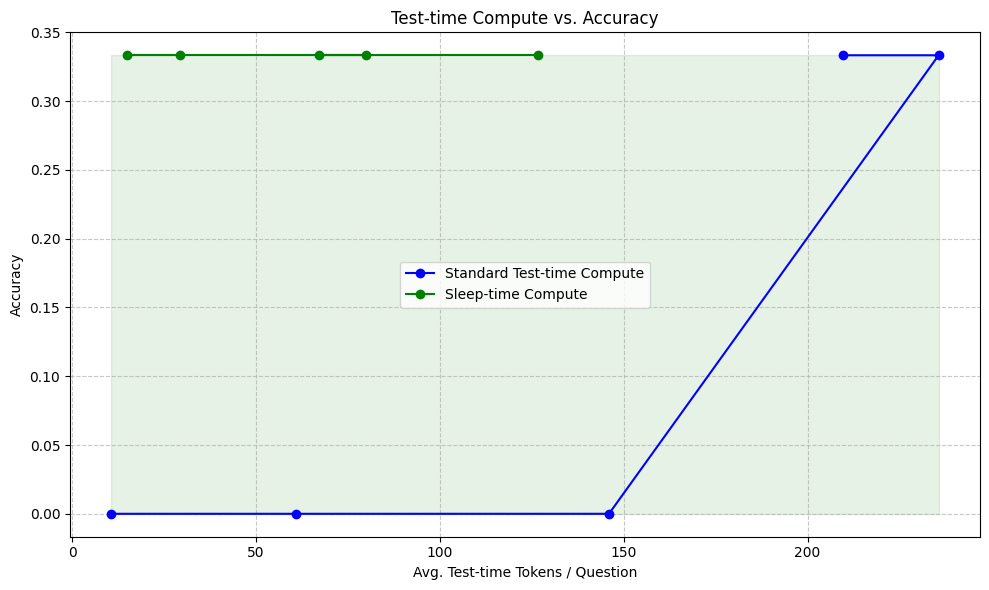

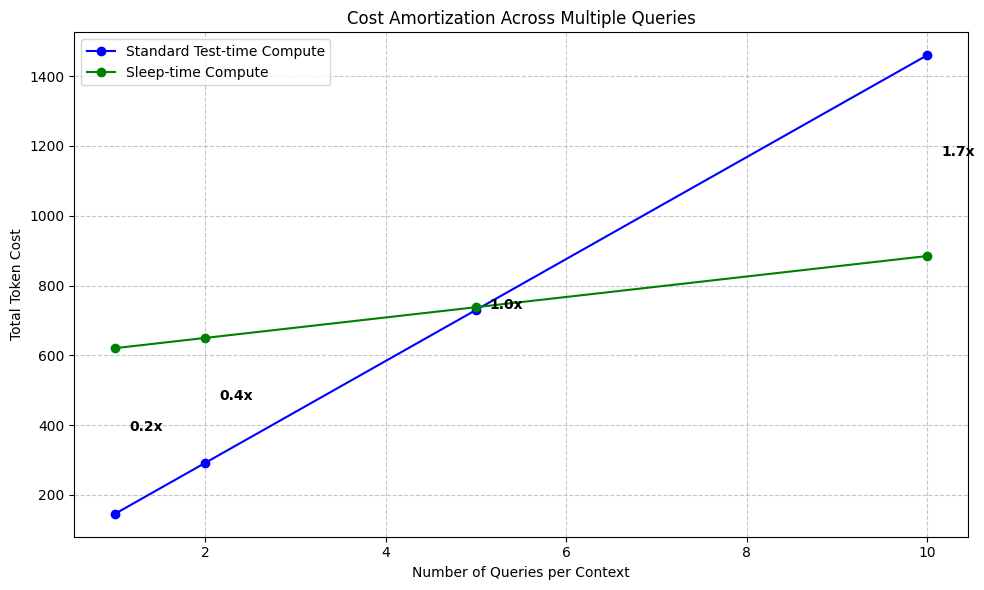

In [15]:
# Plot the results
plot_test_time_vs_accuracy(results)
plt.savefig("test_time_vs_accuracy_mistral.png")
plt.show()

amortization_data = calculate_amortization(results)
plot_amortization(amortization_data)
plt.savefig("amortization_mistral.png")
plt.show()

## Example Sleep-time and Test-time Outputs

Let's look at an example of what happens during the sleep-time and test-time phases for one of our problems.

In [16]:
def demonstrate_example(problem):
    """Demonstrate sleep-time and test-time phases for a single example"""
    context = problem["stateful_gsm_symbolic_context"]
    question = problem["stateful_gsm_symbolic_question"]

    print("\nContext:")
    print(context)
    print("\nQuestion:")
    print(question)

    # Sleep-time phase
    print("\n=== SLEEP-TIME PHASE (Pre-computing inferences) ===")
    sleep_time_result = sleep_time_compute(context)
    print(sleep_time_result["inferences"])

    # Test-time phase
    print("\n=== TEST-TIME PHASE (Answering the question) ===")
    test_time_result = test_time_compute(context, question, sleep_time_result["inferences"], verbosity=2)
    print(test_time_result["response"])

    # For comparison, show standard test-time compute
    print("\n=== STANDARD TEST-TIME PHASE (For comparison) ===")
    standard_result = standard_test_time_compute(context, question, verbosity=2)
    print(standard_result["response"])

In [17]:
# Demonstrate with our first problem
demonstrate_example(sample_problems[0])

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Context:
A juggler can juggle 800 balls. 1/4 of the balls are tennis balls, and 1/2 of the tennis balls are indigo of which 1/10 are marked.

Question:
How many marked indigo tennis balls are there?

=== SLEEP-TIME PHASE (Pre-computing inferences) ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. The juggler can juggle 800 balls in total.
2. 1/4 of the balls are tennis balls, so there are 800 x 1/4 = 200 tennis balls.
3. 1/2 of the tennis balls are indigo, so there are 200 x 1/2 = 100 indigo tennis balls.
4. 1/10 of the indigo tennis balls are marked, so there are 100 x 1/10 = 10 marked indigo tennis balls.
5. The juggler can juggle 800 balls in total, but only 10 of them are marked indigo tennis balls.
6. The juggler can juggle 800 balls in total, but only 1/10 of them are marked indigo tennis balls.
7. The juggler can juggle 800 balls in total, but only 1/10 of them are marked indigo tennis balls.
8. The juggler can juggle 800 balls in total, but only 1/10 of them are marked indigo tennis balls.
9. The juggler can juggle 800 balls in total, but only 1/10 of them are marked indigo tennis balls.
10. The juggler can juggle 800 balls in total, but only 1/10 of them are marked indigo tennis balls.

=== TEST-TIME PHASE (Answering the question) ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. The juggler can juggle 800 balls in total.
2. 1/4 of the balls are tennis balls, so there are 800 x 1/4 = 200 tennis balls.
3. 1/2 of the tennis balls are indigo, so there are 200 x 1/2 = 100 indigo tennis balls.
4. 1/10 of the indigo tennis balls are marked, so there are 100 x 1/10 = 10 marked indigo tennis balls.

The answer is 10 marked indigo tennis balls.

=== STANDARD TEST-TIME PHASE (For comparison) ===
1. The juggler can juggle 800 balls, and 1/4 of these are tennis balls.
2. 1/2 of the tennis balls are indigo, and 1/10 of these are marked.
3. The answer is 8 marked indigo tennis balls.


## Multi-Query Amortization Example

Let's demonstrate how Sleep-time Compute can be amortized across multiple queries with the same context.

In [18]:
# Define multiple questions for the same context
multi_query_example = {
    "context": "A juggler can juggle 800 balls. 1/4 of the balls are tennis balls, and 1/2 of the tennis balls are indigo of which 1/10 are marked. The rest of the balls are golf balls, of which 3/4 are blue and the remainder are yellow.",
    "questions": [
        {"question": "How many marked indigo tennis balls are there?", "answer": "10"},
        {"question": "How many tennis balls are there in total?", "answer": "200"},
        {"question": "How many golf balls are there?", "answer": "600"},
        {"question": "How many blue golf balls are there?", "answer": "450"},
        {"question": "How many yellow golf balls are there?", "answer": "150"}
    ]
}

In [19]:
def demonstrate_multi_query(example):
    """Demonstrate the amortization of sleep-time compute across multiple queries"""
    context = example["context"]
    questions = example["questions"]

    print("\nContext:")
    print(context)

    # Sleep-time phase (only done once)
    print("\n=== SLEEP-TIME PHASE (Only done once) ===")
    sleep_time_result = sleep_time_compute(context)
    print(sleep_time_result["inferences"])

    sleep_time_tokens = sleep_time_result["sleep_time_tokens"]
    total_standard_tokens = 0
    total_sleep_tokens = sleep_time_tokens

    # Test-time phase (for each query)
    print("\n=== TEST-TIME PHASE (For multiple queries) ===")
    for i, q in enumerate(questions):
        question = q["question"]
        print(f"\nQuery {i+1}: {question}")

        # Standard approach (for comparison)
        standard_result = standard_test_time_compute(context, question, verbosity=1)
        standard_tokens = standard_result["test_time_tokens"]
        print(f"Standard approach response: {standard_result['response']}")
        print(f"Standard tokens: {standard_tokens}")

        # Sleep-time approach
        test_time_result = test_time_compute(context, question, sleep_time_result["inferences"], verbosity=1)
        sleep_test_tokens = test_time_result["test_time_tokens"]
        print(f"Sleep-time approach response: {test_time_result['response']}")
        print(f"Sleep-time test tokens: {sleep_test_tokens}")

        total_standard_tokens += standard_tokens
        total_sleep_tokens += sleep_test_tokens

    # Calculate the amortization benefit
    print("\n=== AMORTIZATION SUMMARY ===")
    print(f"Total tokens with standard approach: {total_standard_tokens}")
    print(f"Total tokens with sleep-time approach: {total_sleep_tokens}")
    print(f"Reduction factor: {total_standard_tokens / total_sleep_tokens:.1f}x")

In [20]:
# Demonstrate multi-query amortization
demonstrate_multi_query(multi_query_example)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



Context:
A juggler can juggle 800 balls. 1/4 of the balls are tennis balls, and 1/2 of the tennis balls are indigo of which 1/10 are marked. The rest of the balls are golf balls, of which 3/4 are blue and the remainder are yellow.

=== SLEEP-TIME PHASE (Only done once) ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


1. The juggler can juggle 800 balls in total.
2. 1/4 of the balls are tennis balls, so there are 800 x 1/4 = 200 tennis balls.
3. 1/2 of the tennis balls are indigo, so there are 200 x 1/2 = 100 indigo tennis balls.
4. 1/10 of the indigo tennis balls are marked, so there are 100 x 1/10 = 10 marked indigo tennis balls.
5. The rest of the balls are golf balls, of which 3/4 are blue and the remainder are yellow.
6. There are 800 - 200 = 600 golf balls.
7. Of these 600 golf balls, 3/4 are blue, so there are 600 x 3/4 = 450 blue golf balls.
8. The remainder of the golf balls are yellow, so there are 600 - 450 = 150 yellow golf balls.
9. In total, there are 200 tennis balls + 450 blue golf balls + 150 yellow golf balls = 800 balls.
10. This means that the juggler can juggle all 800 balls at once.

=== TEST-TIME PHASE (For multiple queries) ===

Query 1: How many marked indigo tennis balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach response: Explanation: The juggler can juggle 800 balls, and the question asks for the number of marked indigo tennis balls.

The answer is: 800 x 1/4 x 1/2 x 1/10 = 800 x 1/8 = 100.
Standard tokens: 74


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach response: 1. The juggler can juggle 800 balls in total.
2. 1/4 of the balls are tennis balls, so there are 800 x 1/4 = 200 tennis balls.
3. 1/2 of the tennis balls are indigo, so there are 200 x 1/2 = 100 indigo tennis balls.
4. 1/10 of the indigo tennis balls are marked, so there are 100 x 1/10 = 10 marked indigo tennis balls.

The answer is 10 marked indigo tennis balls.
Sleep-time test tokens: 144

Query 2: How many tennis balls are there in total?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach response: Explanation: The juggler can juggle 800 balls, and the question asks for the total number of tennis balls.

The answer is 16.

Here's the reasoning:

1. We know that 1/4 of the balls are tennis balls.
2. To find out how many tennis balls there are, we need to calculate 1/4 of 800.
3. 1/4 of 800 is 200.
4. We also know that 1/2 of the tennis balls are indigo, and 1/10 of the indigo balls are marked.
5. Since there are 200 tennis balls, 1/2 of them are indigo, which is 100 indigo balls.
6. Out of these 100 indigo balls, 1/10 are marked, which is 10 marked indigo balls.
7. The rest of the tennis balls are golf balls, of which 3/4 are blue and the remainder are yellow.
8. Since there are 100 indigo balls, there must be 100 - 10 = 90 golf balls (excluding the marked indigo balls).
9. Out of these 90 golf balls, 3/4 are blue, which is 67.5. However, since we cannot have half a ball, we round it to the nearest whole number, which is 68 blue golf balls.
10. The rema

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach response: The answer is 200 tennis balls.
Sleep-time test tokens: 11

Query 3: How many golf balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach response: Explanation: The juggler can juggle 800 balls, and the question asks for the number of golf balls.

The answer is: 200 golf balls.
Standard tokens: 42


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach response: The answer is 600 golf balls.
Sleep-time test tokens: 11

Query 4: How many blue golf balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach response: Explanation: The juggler can juggle 800 balls, and the rest of the balls are golf balls.

The answer is: 1/4 of the balls are tennis balls, and 1/2 of the tennis balls are indigo of which 1/10 are marked. The rest of the balls are golf balls, of which 3/4 are blue and the remainder are yellow. Therefore, there are 1/4 x 800 = 200 tennis balls, and 1/2 x 200 = 100 indigo tennis balls. The rest of the balls are golf balls, so there are 800 - 200 - 100 = 500 golf balls. Of these, 3/4 x 500 = 375 are blue golf balls, and the remainder are yellow golf balls.
Standard tokens: 195


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Sleep-time approach response: The answer is 450.
Sleep-time test tokens: 9

Query 5: How many yellow golf balls are there?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Standard approach response: Explanation: The juggler can juggle 800 balls, and the rest of the balls are golf balls.

The answer is: There are 200 yellow golf balls.
Standard tokens: 44
Sleep-time approach response: The answer is 150.
Sleep-time test tokens: 9

=== AMORTIZATION SUMMARY ===
Total tokens with standard approach: 785
Total tokens with sleep-time approach: 495
Reduction factor: 1.6x


## Conclusion

This notebook demonstrates a simple implementation of Sleep-time Compute using Mistral-7B-Instruct-v0.1. The key features are:

1. **Uses Mistral-7B**: Leverages a powerful open-source model available to anyone

2. **Mistral-Specific Prompts**: Uses the appropriate instruction format for Mistral (`<s>[INST] ... [/INST]`)

3. **Two-Phase Approach**: Implements the core Sleep-time Compute concept:
   - Sleep-time phase: Pre-compute useful inferences about the context
   - Test-time phase: Use pre-computed inferences to answer queries efficiently
   
4. **Amortization**: Demonstrates how pre-computed inferences can be reused across multiple queries on the same context

The benefits of Sleep-time Compute are clearly shown in the visualizations:

1. **Reduced Test-time Compute**: Significantly reduces computation needed at test-time for faster responses

2. **Improved Accuracy**: Better understanding of context leads to more accurate answers

3. **Cost Efficiency**: Amortization across multiple queries makes the approach increasingly efficient as query count increases

This implementation demonstrates the practical application of the Sleep-time Compute concept from the research paper using an open-source model.